In [ ]:
# ipynb to produce visualization of gait phases (double support, single support, swing)
# option to visualize with bottom-up segmentation strategy plotted as well

In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
import os
import scipy.io as sio
from scipy.integrate import cumulative_trapezoid
import matplotlib.pyplot as plt
import torch
from scipy.interpolate import interp1d
from scipy.signal import find_peaks, savgol_filter, butter, filtfilt
from torch.utils.data import Dataset, DataLoader
import scipy

import matplotlib.animation as animation
import matplotlib.colors as mcolors


from matplotlib.animation import FuncAnimation
import cv2 as cv


In [2]:
def segment_insole_data(insole_data):
    toe_region = insole_data[:, :13, :]  # Toe
    forefoot_region = insole_data[:, 13:31, :]  # Forefoot
    midfoot_region = insole_data[:, 32:42, :]  #  Midfoot
    heel_region = insole_data[:, 42:, :]  #  Heel
    return heel_region, midfoot_region, forefoot_region, toe_region

def butter_lowpass_filter(data, cutoff=8, fs=100, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

def reshape_insole_grid(data):
    num_frames = data.shape[0]
    reshaped_data = np.empty((num_frames, 64, 16), dtype=data.dtype)
    for i in range(num_frames):
        frame = data[i].reshape(16, 64).T.copy()
        frame[:32, :] = np.flipud(frame[:32, :])
        reshaped_data[i] = frame

    return reshaped_data

def gait_segmentation(insole, h_th, t_th, ms_th):

    insole = reshape_insole_grid(insole)
    heel_region, midfoot_region, forefoot_region, toe_region = segment_insole_data(insole)
    p_heel = np.mean(heel_region, axis=(1, 2))
    p_toe = np.mean(toe_region, axis=(1, 2))
    p_forefoot = np.mean(forefoot_region, axis=(1, 2))
    p_insole = (insole > 25).astype(int)

    p_heel_filtered = butter_lowpass_filter(p_heel, 8, 75)
    p_fore_filtered = butter_lowpass_filter(p_forefoot+p_toe, 8, 75)
    p_foot_filtered = butter_lowpass_filter(np.sum(insole, axis=(1, 2)), 8, 75)
#     plt.figure()
#     plt.plot(p_foot_filtered, label = "foot")
#     plt.plot(p_fore_filtered, label = "fore")
#     plt.plot(p_heel_filtered, label = "heel")
#     plt.xlim(2020, 2090)
#     plt.legend()

    p_heel_derivative = np.gradient(p_heel_filtered)
    p_fore_derivative = np.gradient(p_fore_filtered)

    hc_indices, _ = find_peaks(p_heel_derivative, height=h_th, distance=10)
    to_indices, _ = find_peaks(-p_fore_derivative, height=t_th, distance=10)
    ms_indices, _ = find_peaks(p_foot_filtered, height=ms_th, distance=30)
    
    return hc_indices, to_indices, ms_indices, p_heel_derivative, p_fore_derivative



def resample_data(data):
    n = data.shape[0]
    index = np.linspace(0, 100, n)
    target = np.linspace(0, 100, 100)
    resampled_data = np.zeros((100, 3))
    for i in range(3):
        interp_func = interp1d(index, data[:, i])
        resampled_data[:, i] = interp_func(target)

    return resampled_data


def get_gait_parameters_insole2(insole_r, insole_l, t_r, t_l, thresholds):
    """
    Get gait parameters from insole data
    """

    [h_th_r, t_th_r, h_th_l, t_th_l, ms_th_r, ms_th_l, strike_th_l, strike_th_r] = thresholds

    gait = {'foot_trace_r': np.zeros(len(t_r)), 'foot_trace_l': np.zeros(len(t_l)),
            'dim': [int(np.sqrt(insole_r.shape[1]) * 2), int(np.sqrt(insole_r.shape[1]) / 2)],
            'cop_x_r': np.zeros(len(t_r)),
            'cop_y_r': np.zeros(len(t_r)),
            'cont_area_r': np.zeros(len(t_r)),
            'cop_x_l': np.zeros(len(t_l)),
            'cop_y_l': np.zeros(len(t_l)),
            'cont_area_l': np.zeros(len(t_l)),
            }
    insole_data = {'insole_r_flipped':[],
            'insole_l_flipped':[]}
    
    pressures = {}

    for i in range(len(t_r)):
        frame = insole_r[i, :].reshape(gait['dim'][0], gait['dim'][1], order='F')
        frame[:gait['dim'][0] // 2, :] = np.flipud(frame[:gait['dim'][0] // 2, :])
        gait['foot_trace_r'][i] = np.mean(frame)
        insole_data['insole_r_flipped'].append(frame)
        x, y = np.where(frame > 0)

        # COP
        sum_frame_r = np.sum(frame[x, y])
        if sum_frame_r > 0:
            gait['cop_x_r'][i] = np.sum(x * frame[x, y]) / sum_frame_r
            gait['cop_y_r'][i] = np.sum(y * frame[x, y]) / sum_frame_r
        else:
            gait['cop_x_r'][i] = np.nan
            gait['cop_y_r'][i] = np.nan

        gait['cont_area_r'][i] = len(x)


    for i in range(len(t_l)):
        frame = insole_l[i, :].reshape(gait['dim'][0], gait['dim'][1], order='F')
        frame[:gait['dim'][0] // 2, :] = np.flipud(frame[:gait['dim'][0] // 2, :])
        insole_data['insole_l_flipped'].append(frame)
        gait['foot_trace_l'][i] = np.mean(insole_l[i,:])


    # Gait events
    hc_indices, to_indices, ms_indices, p_heel_filtered, p_fore_filtered = gait_segmentation(insole_r, h_th_r, t_th_r, ms_th_r)
    strike_r = sorted(hc_indices)
    off_r = sorted(to_indices)
    ms_r = sorted(ms_indices)
    pressures['heel_r'] = p_heel_filtered
    pressures['toe_r'] = p_fore_filtered

    hc_indices, to_indices, ms_indices, p_heel_filtered, p_fore_filtered = gait_segmentation(insole_l, h_th_l, t_th_l, ms_th_l)
    strike_l = hc_indices
    off_l = to_indices
    ms_l = ms_indices
    pressures['heel_l'] = p_heel_filtered
    pressures['toe_l'] = p_fore_filtered

    # Isolate complete gait cycles
    gait['step_r'] = []
    gait['step_l'] = []
    for i in range(len(strike_r) - 1):
        start, end = strike_r[i], strike_r[i + 1]
        if t_r[end] - t_r[start] > strike_th_r:
            continue
        step_off = [o for o in off_r if start <= o <= end]
        ms = [j for j in ms_r if start <= j <= end]
        if len(step_off) == 1:
            gait['step_r'].append({'strike': [start, end], 'ms': ms,'off': step_off})

    for i in range(len(strike_l) - 1):
        start, end = strike_l[i], strike_l[i + 1]
        if t_l[end] - t_l[start] > strike_th_l:
            continue
        step_off = [o for o in off_l if start <= o <= end]
        ms = [j for j in ms_l if start <= j <= end]

        if len(step_off) == 1:
            gait['step_l'].append({'strike': [start, end], 'ms': ms, 'off': step_off})

    # Cycle duration
    gait['cycle_dur_l'] = np.zeros((len(gait['step_l'])))
    gait['swing_dur_l']= np.zeros((len(gait['step_l'])))
    gait['stance_dur_l'] = np.zeros((len(gait['step_l'])))
    gait['cadence_l'] = np.zeros(len(gait['cycle_dur_l']))
    gait['cycle_dur_r'] = np.zeros((len(gait['step_r'])))
    gait['swing_dur_r']= np.zeros((len(gait['step_r'])))
    gait['stance_dur_r'] = np.zeros((len(gait['step_r'])))
    gait['cadence_r'] = np.zeros(len(gait['cycle_dur_r']))

    for i in range((len(gait['step_l']))):
        start, end = gait['step_l'][i]['strike']
        off = gait['step_l'][i]['off']
        gait['cycle_dur_l'][i] = t_l[end] - t_l[start]
        gait['stance_dur_l'][i] = t_l[off] - t_l[start]
    gait['swing_dur_l'] = gait['cycle_dur_l'] - gait['stance_dur_l']
    gait['stance_phase_l'] = gait['stance_dur_l']/gait['cycle_dur_l']
    gait['swing_phase_l'] = gait['swing_dur_l'] / gait['cycle_dur_l']
    gait['cadence_l'] = 60/gait['cycle_dur_l']

    for i in range((len(gait['step_r']))):
        start, end = gait['step_r'][i]['strike']
        off = gait['step_r'][i]['off']
        gait['cycle_dur_r'][i] = t_r[end] - t_r[start]
        gait['stance_dur_r'][i] = t_r[off] - t_r[start]
    gait['swing_dur_r'] = gait['cycle_dur_r'] - gait['stance_dur_r']
    gait['stance_phase_r'] = gait['stance_dur_r']/gait['cycle_dur_r']
    gait['swing_phase_r'] = gait['swing_dur_r'] / gait['cycle_dur_r']
    gait['cadence_r'] = 60/gait['cycle_dur_r']

    gait['swing_asym'] = np.abs((np.mean(gait['swing_phase_l']) - np.mean(gait['swing_phase_r']))) / (
            0.5 * (np.mean(gait['swing_phase_l']) + np.mean(gait['swing_phase_r'])))

    return gait, insole_data, pressures

In [3]:
insole_data_path = Path("data")
insole_data = sio.loadmat(insole_data_path / "gait_recording_080624_walk.mat")

In [4]:
print(insole_data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'insoleAll_l', 'insoleAll_r', 'jnt_angles_all_l', 'jnt_angles_all_r', 'jnt_pos_all_l', 'jnt_pos_all_r', 'tAll_l', 'tAll_r', 't_insole_l', 't_insole_r', 't_trackers'])


In [5]:
insole_l = insole_data['insoleAll_l']
insole_r = insole_data['insoleAll_r']
t_l = insole_data['t_insole_l']
t_r = insole_data['t_insole_r']
thresholds = [30, 30, 30,30, 10000,10000, 2, 2] #[h_th_r, t_th_r, h_th_l, t_th_l, ms_th_r, ms_th_l, strike_th_l, strike_th_r] 

In [6]:
gait, insole_data, pressures = get_gait_parameters_insole2(insole_r, insole_l, t_r, t_l, thresholds)

In [7]:
strike_indices_l = [step['strike'][0] for step in gait['step_l']]
off_indices_l = [idx for step in gait['step_l'] for idx in step['off']]
ms_indices_l = [idx for step in gait['step_l'] for idx in step['ms']]

strike_indices_r = [step['strike'][0] for step in gait['step_r']]
off_indices_r = [idx for step in gait['step_r'] for idx in step['off']]
ms_indices_r = [idx for step in gait['step_r'] for idx in step['ms']]

Text(0.5, 0, 'Frame indices')

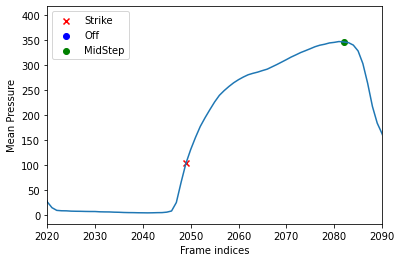

In [8]:
plt.plot(gait['foot_trace_l'])
# Plot 'strike' with 'x' markers
plt.scatter(strike_indices_l, [gait['foot_trace_l'][idx] for idx in strike_indices_l], 
            color='red', marker='x', label="Strike")

# Plot 'off' with 'o' markers
plt.scatter(off_indices_l, [gait['foot_trace_l'][idx] for idx in off_indices_l], 
            color='blue', marker='o', label="Off")

# Plot 'off' with 'o' markers
plt.scatter(ms_indices_l, [gait['foot_trace_l'][idx] for idx in ms_indices_l], 
            color='green', marker='o', label="MidStep")
plt.legend()
plt.xlim(2020, 2090)

plt.ylabel("Mean Pressure")
plt.xlabel("Frame indices")


In [9]:
def produce_step_slice(strike_indices, off_indices, ms_indices, insole_all):
    # Steps from heel strike to toe off
    steps_se = zip(strike_indices, off_indices)
    return [np.stack(insole_all[s:e], axis=0) for s, e in steps_se]

def produce_phase_slice(strike_indices, off_indices, ms_indices, insole_all):
    # Double support from heel strike to mid stance
    ds_startend = zip(strike_indices, ms_indices)
    ds_frames = np.vstack([np.stack(insole_all[s:e], axis=0) for s, e in ds_startend])

    # Single support from mid stance to toe off
    ss_startend = zip(ms_indices, off_indices)
    ss_frames = np.vstack([np.stack(insole_all[s:e], axis=0) for s, e in ss_startend])

    # Swing from toe off to next heel strike
    swing_startend = zip(off_indices[:-1], strike_indices[1:])
    swing_frames = np.vstack([np.stack(insole_all[s:e], axis=0) for s, e in swing_startend])

    return {"double": ds_frames, "single": ss_frames, "swing": swing_frames}

def start_end_phases(strike_indices, off_indices, ms_indices, insole_all):
    # Double support from heel strike to mid stance
    ds_startend = list(zip(strike_indices, ms_indices))

    # Single support from mid stance to toe off
    ss_startend = list(zip(ms_indices, off_indices))

    # Swing from toe off to next heel strike
    swing_startend = list(zip(off_indices[:-1], strike_indices[1:]))

    return {"double": ds_startend, "single": ss_startend, "swing": swing_startend}

In [10]:
step_segments_l = produce_step_slice(strike_indices_l, off_indices_l, ms_indices_l, insole_data['insole_l_flipped'])

In [11]:
step_segments_r = produce_step_slice(strike_indices_r, off_indices_r, ms_indices_r, insole_data['insole_r_flipped'])

In [12]:
phase_segments_l = start_end_phases(strike_indices_l, off_indices_l, ms_indices_l, insole_data['insole_l_flipped'])

In [13]:
phase_segments_r = start_end_phases(strike_indices_r, off_indices_r, ms_indices_r, insole_data['insole_r_flipped'])

In [14]:
def convert_insole_spatial(insoleAll_l: np.ndarray, insoleAll_r: np.ndarray):
    # from Sam's MATLAB files
    # use FORTRAN row-major reordering
    insole_spatial_l = insoleAll_l.reshape((-1, 64, 16), order="F")
    insole_spatial_r = insoleAll_r.reshape((-1, 64, 16), order="F")

    # need to flip the top half of the heatmap up-down
    insole_spatial_l[:, :32, :] = np.flip(insole_spatial_l[:, :32, :], axis=1)
    insole_spatial_r[:, :32, :] = np.flip(insole_spatial_r[:, :32, :], axis=1)

    # also flip the right insole left-right
    # Sam doesn't do this IIRC but it looks right
    insole_spatial_r = np.flip(insole_spatial_r, axis=2)

    return insole_spatial_l, insole_spatial_r

In [15]:
def compute_height_seg_coords(insole_spatial: np.ndarray, validate: bool = True, show_plot: bool = False) -> np.ndarray:
    NVALLEYS = 2
    NPEAKS = NVALLEYS + 1

    # mean across frames and columns
    colwise_mean = insole_spatial.mean(axis=(0, 2))

    # remove outliers i.e. a row of dead pixels
    # important the dead pixels don't create a large valley in the middle of the heel
    # which will blow out the toes
    medianed = scipy.signal.medfilt(colwise_mean, kernel_size=3)
    # smoothing filter
    # polyorders 2 and 3 have same effect because they share a center
    # window_length > 5 causes noticable drift in extrema locations
    smoothed = scipy.signal.savgol_filter(medianed, window_length=5, polyorder=2)

    # invert to get min instead of max
    valleys, valley_props = scipy.signal.find_peaks(-smoothed, prominence=0)

    valleys_mask = np.argsort(valley_props["prominences"])[-NVALLEYS:]

    peaks, peak_props = scipy.signal.find_peaks(smoothed, prominence=0)
    peaks_mask = np.argsort(peak_props["prominences"])[-NPEAKS:]

    if show_plot:
        plt.plot(colwise_mean, label="colwise mean")
        plt.plot(medianed, label="medianed")
        plt.plot(smoothed, label="smoothed")

        plt.plot(
            valleys[valleys_mask], smoothed[valleys[valleys_mask]], "o", label="valleys"
        )
        plt.vlines(
            x=valleys[valleys_mask],
            ymin=smoothed[valleys[valleys_mask]],
            ymax=valley_props["prominences"][valleys_mask]
            + smoothed[valleys[valleys_mask]],
            color="C3",
        )

        plt.plot(peaks[peaks_mask], smoothed[peaks[peaks_mask]], "x", label="peaks")
        plt.vlines(
            x=peaks[peaks_mask],
            ymin=smoothed[peaks[peaks_mask]] - peak_props["prominences"][peaks_mask],
            ymax=smoothed[peaks[peaks_mask]],
            color="C4",
        )

        plt.legend()
        plt.show()

    if validate:
        peak_valley_sorted = np.sort(
            np.hstack((peaks[peaks_mask], valleys[valleys_mask]))
        )

        # we want the ordering to be peak, valley, peak, valley, peak
        if not np.all(np.diff(np.isin(peak_valley_sorted, peaks[peaks_mask]))):
            raise Exception("validation failed")

    return valleys[valleys_mask]

def compute_width_seg_coords(insole_spatial: np.ndarray,height_valleys: np.ndarray,
    validate: bool = True,show_plot: bool = False,) -> np.ndarray:
    NVALLEYS = np.array([1, 1, 0])
    NPEAKS = NVALLEYS + 1
    TITLES = ["Toe", "Ball", "Heel"]

    # add 0 and len as bounds for window slide
    valleys_pad = np.r_[0, height_valleys, insole_spatial.shape[1]]

    width_valleys = []

    for i, window in enumerate(np.lib.stride_tricks.sliding_window_view(valleys_pad, 2)):
        # mean across frames and rows
        rowwise_mean = insole_spatial[:, window[0] : window[1], :].mean(axis=(0, 1))

        # remove outliers i.e. a row of dead pixels
        # important the dead pixels don't create a large valley in the middle of the heel
        # which will blow out the toes
        medianed = scipy.signal.medfilt(rowwise_mean, kernel_size=3)
        # smoothing filter
        # polyorders 2 and 3 have same effect because they share a center
        # window_length > 5 causes noticable drift in extrema locations
        smoothed = scipy.signal.savgol_filter(medianed, window_length=5, polyorder=2)

        # invert to get min instead of max
        valleys, valley_props = scipy.signal.find_peaks(-smoothed, prominence=0)

        valleys_mask = np.argsort(valley_props["prominences"])[-NVALLEYS[i] :]

        peaks, peak_props = scipy.signal.find_peaks(smoothed, prominence=0)
        peaks_mask = np.argsort(peak_props["prominences"])[-NPEAKS[i] :]

        if show_plot:
            plt.plot(rowwise_mean, label="rowwise mean")
            plt.plot(medianed, label="medianed")
            plt.plot(smoothed, label="smoothed")

            plt.plot(
                valleys[valleys_mask],
                smoothed[valleys[valleys_mask]],
                "o",
                label="valleys",
            )
            plt.vlines(
                x=valleys[valleys_mask],
                ymin=smoothed[valleys[valleys_mask]],
                ymax=valley_props["prominences"][valleys_mask]
                + smoothed[valleys[valleys_mask]],
                color="C3",
            )

            plt.plot(peaks[peaks_mask], smoothed[peaks[peaks_mask]], "x", label="peaks")
            plt.vlines(
                x=peaks[peaks_mask],
                ymin=smoothed[peaks[peaks_mask]]
                - peak_props["prominences"][peaks_mask],
                ymax=smoothed[peaks[peaks_mask]],
                color="C4",
            )

            plt.title(TITLES[i])

            plt.legend()
            plt.show()

        if validate:
            peak_valley_sorted = np.sort(
                np.hstack((peaks[peaks_mask], valleys[valleys_mask]))
            )

            # we want the ordering to be peak, valley, peak, etc.
            if not np.all(np.diff(np.isin(peak_valley_sorted, peaks[peaks_mask]))):
                raise Exception("validation failed")

        width_valleys.append(valleys)

    # don't keep empty heel valleys array
    return np.vstack(width_valleys[:-1])

In [16]:
COLOR_CYCLE = ["red", "blue", "black","brown","cyan"]

def cycle_color():
    """Choose a color from the predefined cycle."""
    return np.random.choice(COLOR_CYCLE)

In [ ]:
def plot_heatmap_spatial(
    insole_spatial_l: np.ndarray, 
    insole_spatial_r: np.ndarray, 
    strike_indices_r: list, 
    midstance_indices_r: list,
    toe_off_indices_r: list,
    strike_indices_l: list, 
    midstance_indices_l: list,
    toe_off_indices_l: list,
    save_anim: bool
) -> None:
    fig, (ax_l, ax_r) = plt.subplots(1, 2, figsize=(6, 6))

    # Initialize heatmaps
    img_l = ax_l.imshow(
        np.zeros((64, 16)),
        vmin=np.min(insole_spatial_l),
        vmax=np.max(insole_spatial_l),
        interpolation="nearest",
    )
    img_r = ax_r.imshow(
        np.zeros((64, 16)),
        vmin=np.min(insole_spatial_r),
        vmax=np.max(insole_spatial_r),
        interpolation="nearest",
    )

    ax_l.set_title("Left Heatmap")
    ax_r.set_title("Right Heatmap")
    plt.colorbar(img_l, ax=ax_l)
    plt.colorbar(img_r, ax=ax_r)

    # Store hlines and vlines for each strike index
    hlines_r, vlines_r = [], []
    hlines_l, vlines_l = [], []

    """COMMENT OUT THIS SECTION BELOW FOR VISUALIZATION W/O SEGMENTS"""
    
#     for j in range(len(height_valleys_r)):
#         color_choice = cycle_color()
#         hlines_r.append([
#             ax_r.axhline(height_valley_r, color=color_choice, linestyle="--", visible=False)
#             for height_valley_r in height_valleys_r[j]
#         ])

#         # Ensure vlines_r[j] is always a list (even if empty)
#         if np.isin(None, width_valleys_r[j]):
#             vlines_r.append([])  # Store an empty list explicitly
#         else:
#             vlines_r.append([
#                 ax_r.vlines(
#                     width_valley_r,
#                     height_valleys_r[j][i - 1] if i > 0 else 0,
#                     height_valley_r,
#                     color=color_choice,
#                     linestyle="--",
#                     visible=False,
#                 )
#                 for i, (height_valley_r, width_valley_r) in enumerate(
#                     zip(height_valleys_r[j], width_valleys_r[j])
#                 )
#             ])

#     for j in range(len(height_valleys_r)):
#         color_choice = cycle_color()

#         hlines_l.append([
#             ax_l.axhline(height_valley_l, color=color_choice, linestyle="--", visible=False)
#             for height_valley_l in height_valleys_l[j]
#         ])

#         # Ensure vlines_l[j] is always a list (even if empty)
#         if np.isin(None, width_valleys_l[j]):
            
#             vlines_l.append([])  # Store an empty list explicitly
#         else:
#             vlines_l.append([
#                 ax_l.vlines(
#                     width_valley_l,
#                     height_valleys_l[j][i - 1] if i > 0 else 0,
#                     height_valley_l,
#                     color=color_choice,
#                     linestyle="--",
#                     visible=False,
#                 )
#                 for i, (height_valley_l, width_valley_l) in enumerate(
#                     zip(height_valleys_l[j], width_valleys_l[j])
#                 )
#             ])

    """COMMENT OUT THIS SECTION ABOVE FOR VISUALIZATION W/O SEGMENTS"""
     # Function to determine colormap based on phase
    def get_colormap(frame, strike_indices, midstance_indices, toe_off_indices):
        for i in range(len(strike_indices) - 1):
            if strike_indices[i] <= frame < midstance_indices[i]:
                return "Greens"
            elif midstance_indices[i] <= frame < toe_off_indices[i]:
                return "Oranges"
            elif toe_off_indices[i] <= frame < strike_indices[i + 1]:
                return "Purples"
        return "Greens"  # Default colormap
    
    
    # Function to find the active index range
    def find_active_index(frame, strike_indices):
        """Find the segment index for the current frame based on strike indices."""
        for i in range(len(strike_indices) - 1):
            if strike_indices[i] <= frame < strike_indices[i + 1]:
                return i
        return len(strike_indices) - 1  # Use last segment if frame exceeds last strike index

#     # Function to get valid vlines (fallback to previous if empty)
#     def get_valid_vlines(vlines, idx):
#         """Returns vlines[idx] if not empty, otherwise finds the last non-empty vlines."""
#         while idx >= 0 and len(vlines[idx]) == 0:  # Keep going back if empty
#             idx -= 1
#         return vlines[idx] if idx >= 0 else vlines[0]  # Return found vlines or empty list
    
    FRAME_OFFSET = 520
    # Update function for animation
    def update(frame):
        """Update function to modify visible hlines, vlines, and heatmaps while maintaining phase-based transitions."""

        # Offset frame to start at 215
        actual_frame = frame + FRAME_OFFSET  

        idx_r = find_active_index(actual_frame, strike_indices_r)
        idx_l = find_active_index(actual_frame, strike_indices_l)
        
         # Determine colormap based on phase
        cmap_r = get_colormap(actual_frame, strike_indices_r, midstance_indices_r, toe_off_indices_r)
        cmap_l = get_colormap(actual_frame, strike_indices_l, midstance_indices_l, toe_off_indices_l)


        # Update heatmaps every frame while maintaining the same phase
        img_l.set_array(insole_spatial_l[actual_frame, :, :])
        img_r.set_array(insole_spatial_r[actual_frame, :, :])
        # Update colormap dynamically
        img_l.set_cmap(cmap_l)
        img_r.set_cmap(cmap_r)
        
        """COMMENT OUT THIS SECTION BELOW FOR VISUALIZATION W/O SEGMENTS"""
#         # Get valid vlines (fallback to previous if needed)
#         vlines_r_active = get_valid_vlines(vlines_r, idx_r)
#         vlines_l_active = get_valid_vlines(vlines_l, idx_l)

#         # Hide all lines first
#         for lines in hlines_r + vlines_r + hlines_l + vlines_l:
#             for line in lines:
#                 if isinstance(line, list):
#                     for l in line:
#                         l.set_visible(False)
#                 else:
#                     line.set_visible(False)

#         # Show only the relevant lines for the current phase
#         for hline in hlines_r[idx_r]:
#             hline.set_visible(True)
#         for vline in vlines_r_active:
#             if isinstance(vline, list):
#                 for v in vline:
#                     v.set_visible(True)
#             else:
#                 vline.set_visible(True)

#         for hline in hlines_l[idx_l]:
#             hline.set_visible(True)
#         for vline in vlines_l_active:
#             if isinstance(vline, list):
#                 for v in vline:
#                     v.set_visible(True)
#             else:
#                 vline.set_visible(True)
    

#         return img_l, img_r, *hlines_r[idx_r], *hlines_l[idx_l], *vlines_r_active, *vlines_l_active
        """COMMENT OUT THIS SECTION ABOVE FOR VISUALIZATION W/O SEGMENTS"""

        return img_l, img_r


    # Create animation
    ani = animation.FuncAnimation(fig, update, frames=600, blit=False, repeat=True)

    plt.show()

    # Save animation if needed
    if save_anim:
        writervideo = animation.FFMpegWriter(fps=30)
        ani.save("heatmap_animation_finalprez.mp4", writer=writervideo)


In [18]:
feet = ["l", "r"]

height_valleys_r = [compute_height_seg_coords(np.flip(seg, axis = -1), validate=False, show_plot=False) for seg in step_segments_r]

height_valleys_l = [compute_height_seg_coords(seg, validate=False, show_plot=False) for seg in step_segments_l]

    
print(height_valleys_l)
print(len(height_valleys_r))

[array([13, 33]), array([12, 32]), array([13, 32]), array([13, 32]), array([13, 32]), array([13, 32]), array([13, 32]), array([13, 32]), array([13, 32]), array([13, 32]), array([13, 32]), array([13, 32]), array([13, 32]), array([13, 32]), array([13, 32]), array([12, 32]), array([13, 32]), array([13, 32]), array([12, 32]), array([13, 32]), array([13, 32]), array([13, 32]), array([13, 32]), array([13, 32]), array([13, 32]), array([13, 32]), array([13, 32]), array([13, 32]), array([13, 32]), array([13, 32]), array([13, 32]), array([13, 32]), array([13, 32]), array([13, 32]), array([13, 32]), array([13, 32]), array([13, 32]), array([13, 32]), array([13, 32]), array([13, 32]), array([13, 32]), array([13, 32]), array([13, 32]), array([13, 32]), array([13, 32]), array([13, 32]), array([13, 32]), array([13, 32]), array([13, 32]), array([13, 32]), array([13, 32]), array([13, 32]), array([13, 32]), array([13, 32]), array([13, 32]), array([13, 32]), array([13, 32]), array([13, 32]), array([13, 32

In [19]:
width_valleys_l = []
width_valleys_r = []
for i,seg in enumerate(step_segments_l):
    
    try:
        width_valleys_l.append(compute_width_seg_coords(seg, height_valleys_l[i], validate=True, show_plot=False))
    except: 
        width_valleys_l.append(np.array([[ None],[None]]))
        
        
    
for i,seg in enumerate(step_segments_r):
    
    try:
        width_valleys_r.append(compute_width_seg_coords(np.flip(seg, axis = -1), height_valleys_r[i], validate=True, show_plot=False))
    except: 
        width_valleys_r.append(np.array([[ None],[None]]))
    

    
    

print(width_valleys_l)
# print(width_valleys_r)

[array([[ 7],
       [10]]), array([[None],
       [None]], dtype=object), array([[None],
       [None]], dtype=object), array([[None],
       [None]], dtype=object), array([[ 7],
       [10]]), array([[None],
       [None]], dtype=object), array([[None],
       [None]], dtype=object), array([[None],
       [None]], dtype=object), array([[None],
       [None]], dtype=object), array([[None],
       [None]], dtype=object), array([[None],
       [None]], dtype=object), array([[None],
       [None]], dtype=object), array([[None],
       [None]], dtype=object), array([[None],
       [None]], dtype=object), array([[None],
       [None]], dtype=object), array([[ 7],
       [10]]), array([[None],
       [None]], dtype=object), array([[None],
       [None]], dtype=object), array([[ 7],
       [11]]), array([[ 7],
       [10]]), array([[ 7],
       [10]]), array([[None],
       [None]], dtype=object), array([[ 7],
       [10]]), array([[None],
       [None]], dtype=object), array([[ 7],
       [

<ipython-input-15-c83ea7572873>:76: RuntimeWarning: Mean of empty slice.
  rowwise_mean = insole_spatial[:, window[0] : window[1], :].mean(axis=(0, 1))
/Users/andreacheng/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


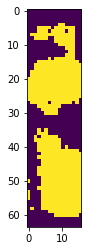

In [ ]:
# Ensure the visuallization looks correct (top and bottom half are not flipped), 
# otherwise, rerun this cell
insole_spatial_l, insole_spatial_r = convert_insole_spatial(insole_l, insole_r)
left_mean= np.mean(insole_spatial_l, axis = 0)
left_mask = (left_mean >= 0.1 * np.max(left_mean)).astype(int)
right_mean= np.mean(insole_spatial_l, axis = 0)
right_mask = (left_mean >= 0.1 * np.max(left_mean)).astype(int)
plt.imshow(left_mask)

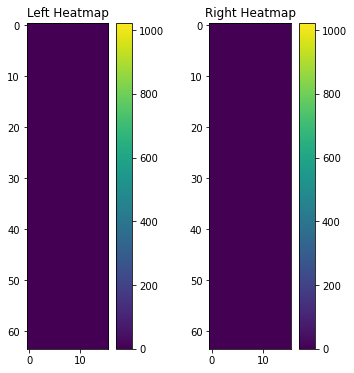

In [29]:
plot_heatmap_spatial(insole_spatial_l, insole_spatial_r, 
                     strike_indices_r, ms_indices_r, off_indices_r, 
                     strike_indices_l, ms_indices_l, off_indices_l, save_anim=True)